<a href="https://colab.research.google.com/github/RBENJAMINFRANKLIN/SBSPS-Challenge-1160-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/blob/master/wind_direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [3]:
window_size = 48
batch_size_exp = 1
epoch_exp = 10
neurons_exp = 50
predict_values_exp = 6000
lag_exp=48

In [7]:

import pandas as pd
data = pd.read_csv('../data/T1.csv',index_col="Date/Time")

In [9]:
data.to_csv('cleaned_data.csv')

In [10]:
dataset = pd.read_csv('cleaned_data.csv', parse_dates=True,index_col="Date/Time")

In [11]:
data = dataset.resample('D').sum()

In [12]:
from matplotlib import pyplot as plt

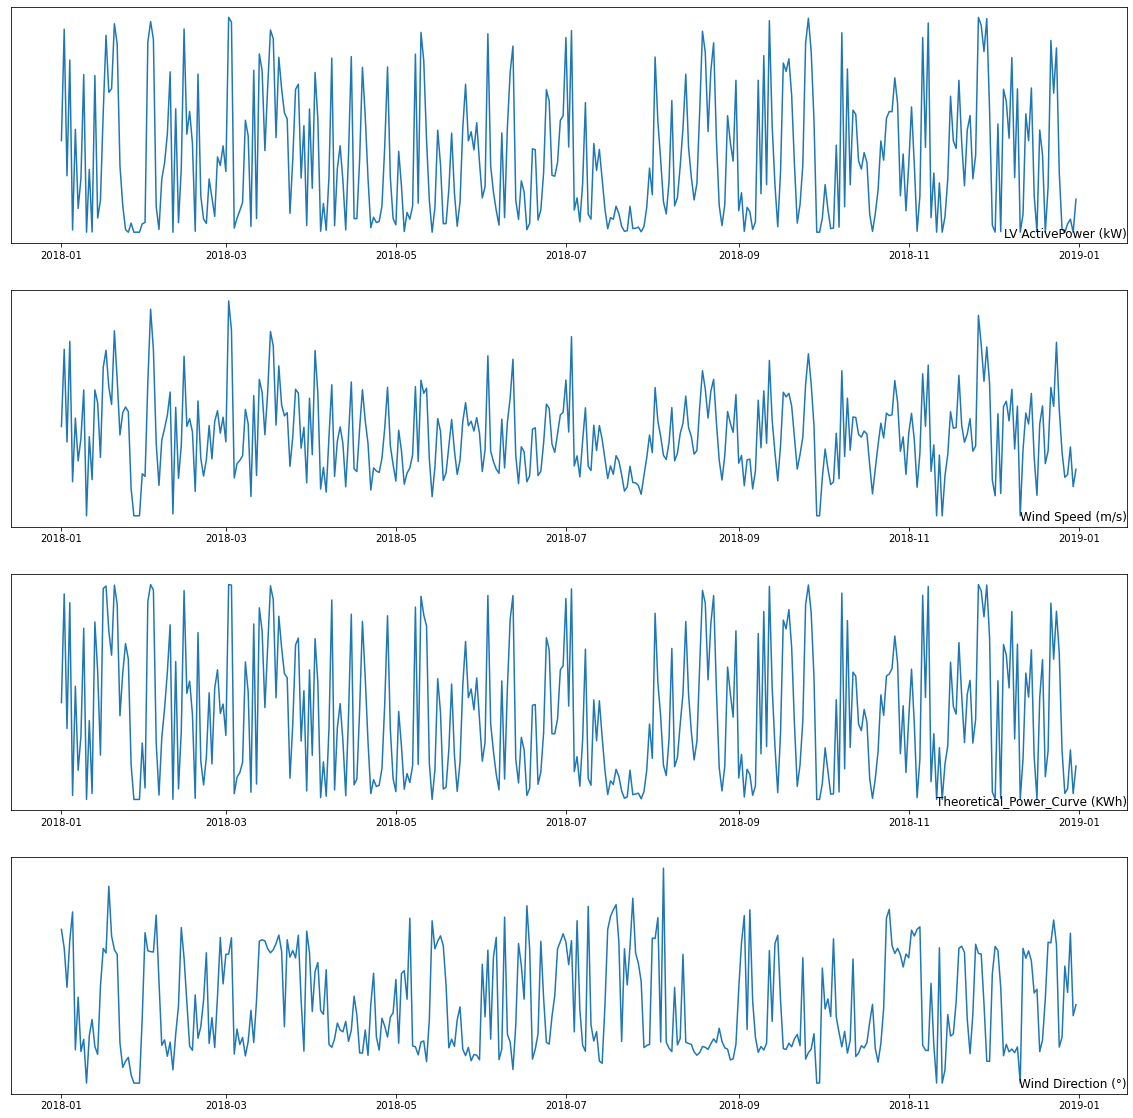

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i+1)
  name = data.columns[i]
  plt.plot(data[name])
  plt.title(name, y=0, loc='right')
  plt.yticks([])
plt.show()
fig.tight_layout ()

In [14]:
years=['2018']

In [16]:
data.loc['2018']

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01,221069.445599,1155.308353,233710.566903,33081.874832
2018-01-02,489997.826721,2153.488136,495800.747854,29051.079056
2018-01-03,136232.521423,954.536103,171240.275532,20612.306661
2018-01-04,415684.403381,2255.877879,474600.579209,30733.485031
2018-01-05,5638.593391,440.559367,9638.282642,36843.185165
...,...,...,...,...
2018-12-27,0.000000,498.415094,14472.857153,25175.384390
2018-12-28,20277.130661,534.476387,25903.554185,19508.626114
2018-12-29,31415.276101,891.476897,119669.963887,32254.909293


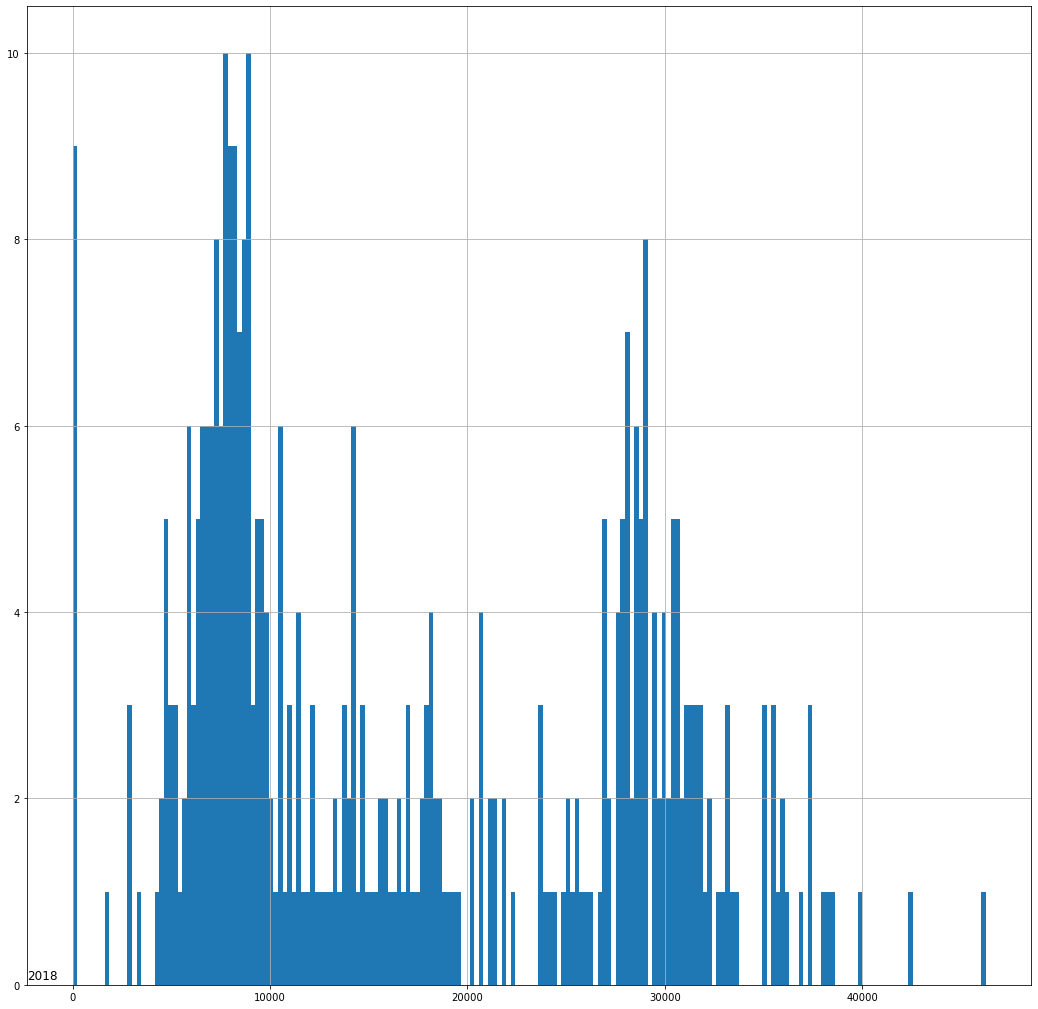

In [19]:
fig, ax = plt.subplots(figsize=(18,18))
for i in range(len(years)):
  plt.subplot(len(years), 1, i+1)
  year = years[i]
  active_power_data = data.loc[str(year)]
  active_power_data['Wind Direction (°)'].hist(bins = 200)
  plt.title(str(year), y = 0, loc = 'left')
plt.show() 
fig.tight_layout()


In [20]:

data_train = data.loc[:'2018-10-31',:]['Wind Direction (°)']
data_train

Date/Time
2018-01-01    33081.874832
2018-01-02    29051.079056
2018-01-03    20612.306661
2018-01-04    30733.485031
2018-01-05    36843.185165
                  ...     
2018-10-27    27909.599655
2018-10-28    29007.160919
2018-10-29    27611.306152
2018-10-30    24990.768890
2018-10-31    27780.833587
Freq: D, Name: Wind Direction (°), Length: 304, dtype: float64

In [21]:
data_test = data.loc['2018-11-01':'2018-12-31',:]['Wind Direction (°)']
data_test


Date/Time
2018-11-01    26989.353104
2018-11-02    32912.813599
2018-11-03    31654.088837
2018-11-04    33115.995506
2018-11-05    33630.758800
                  ...     
2018-12-27    25175.384390
2018-12-28    19508.626114
2018-12-29    32254.909293
2018-12-30    14497.344503
2018-12-31    16871.772377
Freq: D, Name: Wind Direction (°), Length: 61, dtype: float64

In [22]:
data_train.shape

(304,)

In [23]:
data_test.shape

(61,)

In [24]:
data_train.head()

Date/Time
2018-01-01    33081.874832
2018-01-02    29051.079056
2018-01-03    20612.306661
2018-01-04    30733.485031
2018-01-05    36843.185165
Freq: D, Name: Wind Direction (°), dtype: float64

In [25]:
data_train = np.array(data_train)

In [26]:
X_train, y_train = [],[]

for i in range(3, len(data_train)-3):
  X_train.append(data_train[i-3:i])
  y_train.append(data_train[i:i+3])

In [27]:
X_train,y_train=np.array(X_train),np.array(y_train)

In [28]:
X_train.shape, y_train.shape

((298, 3), (298, 3))

In [29]:
pd.DataFrame(X_train).head()

,0,1,2
0,33081.874832,29051.079056,20612.306661
1,29051.079056,20612.306661,30733.485031
2,20612.306661,30733.485031,36843.185165
3,30733.485031,36843.185165,7151.613260
4,36843.185165,7151.613260,18498.549602


In [30]:
x_scalar = MinMaxScaler()
X_train = x_scalar.fit_transform(X_train)

In [31]:
y_scalar = MinMaxScaler()
y_train = y_scalar.fit_transform(y_train)

In [32]:
pd.DataFrame(X_train).head()


,0,1,2
0,0.715178,0.628038,0.445605
1,0.628038,0.445605,0.664409
2,0.445605,0.664409,0.796491
3,0.664409,0.796491,0.154607
4,0.796491,0.154607,0.399909


In [33]:
X_train.shape

(298, 3)

In [34]:
X_train = X_train.reshape(298, 3, 1)

In [35]:
X_train.shape

(298, 3, 1)

In [36]:
reg = Sequential()
reg.add(LSTM(units = 200, activation = 'relu', input_shape=(3,1)))
reg.add(Dense(3))

In [37]:
reg.compile(loss='mse', optimizer='adam')

In [38]:
reg.fit(X_train, y_train, epochs = 100)


Epoch 1/100
10/10 [==============================] - 5s 15ms/step - loss: 0.1606
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1147
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0661
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0554
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0523
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0516
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0504
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0505
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0501
Epoch 10/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0501
Epoch 11/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0498
Epoch 12/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0495
Epoch 13/100
10/10 [===============

In [39]:
data_test = np.array(data_test)

In [40]:
X_test, y_test = [], []

for i in range(3, len(data_test)-3):
  X_test.append(data_test[i-3:i])
  y_test.append(data_test[i:i+3])

In [41]:
X_test, y_test=np.array(X_test), np.array(y_test)

In [42]:
X_test = x_scalar.transform(X_test)
y_test = y_scalar.transform(y_test)

In [43]:
X_test.shape

(55, 3)

In [44]:
X_test = X_test.reshape(55, 3, 1)

In [45]:
y_pred = reg.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [46]:
y_pred = y_scalar.inverse_transform(y_pred)

In [47]:
y_true = y_scalar.inverse_transform(y_test)

In [48]:
y_true

array([[33115.99550629, 33630.75879967,  8131.71406555],
       [33630.75879967,  8131.71406555,  7063.8345356 ],
       [ 8131.71406555,  7063.8345356 ,  6995.28148079],
       [ 7063.8345356 ,  6995.28148079, 21468.86600792],
       [ 6995.28148079, 21468.86600792,  8157.80950069],
       [21468.86600792,  8157.80950069,     0.        ],
       [ 8157.80950069,     0.        , 29116.72072411],
       [    0.        , 29116.72072411,     0.        ],
       [29116.72072411,     0.        ,  2793.34759331],
       [    0.        ,  2793.34759331, 14737.10392174],
       [ 2793.34759331, 14737.10392174, 10112.13514081],
       [14737.10392174, 10112.13514081, 10613.06708145],
       [10112.13514081, 10613.06708145, 17370.42786407],
       [10613.06708145, 17370.42786407, 29016.88545227],
       [17370.42786407, 29016.88545227, 29461.56741333],
       [29016.88545227, 29461.56741333, 28115.14625549],
       [29461.56741333, 28115.14625549, 13706.64304161],
       [28115.14625549, 13706.6

In [49]:
def evaluate_model(y_true, y_predicted):
  scores = []
  #Calculate scores for each day 
  for i in range(y_true.shape[1]):
    mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
    rmse = np.sqrt(mse)
    scores.append(rmse)

    #calculate score for whole prediction 
    total_score = 0
    for row in range(y_true.shape[0]):
      for col in range(y_predicted.shape[1]):
        total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    return total_score, scores



In [50]:
evaluate_model(y_true, y_pred)

(10774.008436412296, [9816.278423948805])

In [51]:
np.std(y_true[0])

11900.889708620449